In [1]:
import pandas as pd
import numpy as np
import re


In [2]:
def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        last_field = " ".join(fields[11:12])
        if(sql_error != ""):
            last_field = sql_error
        row = [fields[1], fields[4], fields[3], fields[10], last_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'est_dialect' , 'DSN' , 'status' , 'error_message']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [6]:
(Classes , Categories) = read_classes("classes.txt")

In [7]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [8]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,est_dialect,DSN,status,error_message,model_category
0,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
1,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
2,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
3,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
4,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn


In [9]:
df[df.error_message == "'"].head(200)

,Model,est_dialect,DSN,status,error_message,model_category


In [10]:
df.DSN.value_counts()

'firebird+fdb://sysdba:db@localhost/db',                          2088
'postgresql://db:db@localhost/db?port=5432',                      2088
'db2+ibm_db://db:db@localhost:50000/db',                          2088
'oracle+cx+oracle://db:db@xe',                                    2088
'sqlite://',                                                      2076
'monetdb://db:db@localhost:50001/db',                             2064
'mysql://db:db@localhost/db',                                     2040
'mssql+pymssql://db:Micro123@db/db2?charset=utf8&timeout=180',    1992
Name: DSN, dtype: int64

In [11]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'None')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [12]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [13]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

error_message
est_dialect error_message                                                    
'pgsql',    SUCCESS                                                      1956
'sqltm',    SUCCESS                                                      1956
'oracle',   SUCCESS                                                      1949
'db2',      SUCCESS                                                      1932
'mysql',    SUCCESS                                                      1914
'mssql',    SUCCESS                                                      1817
'monetdb',  SUCCESS                                                      1370
'firebird', SUCCESS                                                      1020
            'DatabaseError:(fdb.fbcore.DatabaseError)                     497
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  463
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  350
            "DatabaseError:(fdb.fbcore.DatabaseError)                     209
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  127
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  112
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  109
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  108
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  108
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                  106
'monetdb',  ) Math exception: Numerical result out of rang                 92
            'DBAPIError:(builtins.BrokenPipeError)                         60
            'ResourceClosedError:This                                      52
'mssql',    20003, b'DB-Lib error message 20003, severity 6...             41
            "AttributeError:'NoneType'                                     12
'oracle',   "AttributeError:'NoneType'                                     12
'pgsql',    "AttributeError:'NoneType'                                     12
'mysql',    "AttributeError:'NoneType'                                     12
'pgsql',    ) value out of range: underflo                                 12
'sqltm',    "AttributeError:'NoneType'                                     12
'monetdb',  "AttributeError:'NoneType'                                     12
'firebird', "AttributeError:'NoneType'                                     12
'db2',      "AttributeError:'NoneType'                                     12
            'DBAPIError:(ibm_db_dbi.Error)                                 12
            : Fetch Failure: [IBM][CLI Driver][DB2/LINUXX86...             12
'monetdb',  "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              9
'mssql',    8623, b'The query processor ran out of internal...              9
'monetdb',  'IntegrityError:(pymonetdb.exceptions.Integrity...              4
'mssql',    8632, b'Internal error: An expression services ...              4
'mysql',    2002, 'Can't connect to local MySQL server thro...              4
'monetdb',  ) 22003!overflow in calculation 194955857131449...              2
'mysql',    1969, 'Query execution was interrupted (max_sta...              2
            2013, 'Lost connection to MySQL server at 'read...              2
'db2',      : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1

In [14]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,13914
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",1483
'DatabaseError:(fdb.fbcore.DatabaseError),497
"""DatabaseError:(fdb.fbcore.DatabaseError)",209
"""AttributeError:'NoneType'",96
) Math exception: Numerical result out of rang,92
'DBAPIError:(builtins.BrokenPipeError),60
'ResourceClosedError:This,52
"20003, b'DB-Lib error message 20003, severity 6:Adaptive Server connection timed out'",41
'DBAPIError:(ibm_db_dbi.Error),12


In [15]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [16]:
#lGroupBy['rows'].describe()

In [17]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [18]:
real_errors.Model.value_counts()

DummyClassifier                     168
SparsePCA                            96
MiniBatchSparsePCA                   95
LatentDirichletAllocation            93
NMF                                  92
IsolationForest                      90
DummyClassifier_pipe                 84
IsolationForest_pipe                 45
OneVsRestClassifier                  32
AdaBoostClassifier                   22
FactorAnalysis                       14
Perceptron                           12
RidgeClassifier                      12
ExtraTreeClassifier                  12
LogisticRegression                   12
BernoulliNB                          12
PassiveAggressiveClassifier          12
Pipeline                             12
LinearSVC                            12
SGDClassifier                        12
RidgeClassifierCV                    12
DecisionTreeClassifier               12
LinearDiscriminantAnalysis           12
GaussianNB                           12
LogisticRegressionCV                 12


In [19]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [20]:
df.columns

Index(['Model', 'est_dialect', 'DSN', 'status', 'error_message',
       'model_category'],
      dtype='object')

In [21]:
df.head()

,Model,est_dialect,DSN,status,error_message,model_category
0,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
1,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
2,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
3,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn
4,LGBMClassifier,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,lightgbm.sklearn


In [22]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [23]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))


In [24]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird monetdb mssql mysql oracle pgsql   
model_category                                                                  
lightgbm.sklearn                 54       54      54    30    54     54    54   
sklearn.calibration              36       36      36    36    36     36    36   
sklearn.covariance               18       18      18    18    18     18    18   
sklearn.decomposition           120      120     120   120   120    120   120   
sklearn.discriminant_analysis    36       36      36    36    36     36    36   
sklearn.dummy                    54       54      54    54    54     54    54   
sklearn.ensemble                288      288     288   264   288    288   288   
sklearn.feature_selection       108      108     108   108   108    108   108   
sklearn.kernel_ridge             18       18      18    18    18     18    18   
sklearn.linear_model            612      612     612   612   612    612   612   
sklearn.multiclass               72       72      72    72    72     72    72   
sklearn.naive_bayes              84       84      84    84    84     84    84   
sklearn.neural_network           54       54      54    30    54     54    54   
sklearn.pipeline                 48       48      48    48    48     48    48   
sklearn.preprocessing           144      144     144   144   144    144   144   
sklearn.svm                     180      180     156   156   144    180   180   
sklearn.tree                    108      108     108   108   108    108   108   
xgboost.sklearn                  54       54      54    54    42     54    54   
All                            2088     2088    2064  1992  2040   2088  2088   

                                            
dialect                       sqltm    All  
model_category                              
lightgbm.sklearn                 54    408  
sklearn.calibration              36    288  
sklearn.covariance               18    144  
sklearn.decomposition           120    960  
sklearn.discriminant_analysis    36    288  
sklearn.dummy                    54    432  
sklearn.ensemble                276   2268  
sklearn.feature_selection       108    864  
sklearn.kernel_ridge             18    144  
sklearn.linear_model            612   4896  
sklearn.multiclass               72    576  
sklearn.naive_bayes              84    672  
sklearn.neural_network           54    408  
sklearn.pipeline                 48    384  
sklearn.preprocessing           144   1152  
sklearn.svm                     180   1356  
sklearn.tree                    108    864  
xgboost.sklearn                  54    420  
All                            2076  16524

In [25]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [26]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   monetdb     mssql   
model_category                                                          
lightgbm.sklearn               0.148148  0.722222  0.370370  0.166667   
sklearn.calibration            0.000000  1.000000  0.333333  0.000000   
sklearn.covariance             0.222222  0.666667  0.166667  0.000000   
sklearn.decomposition          0.500000  0.583333  0.733333  0.500000   
sklearn.discriminant_analysis  0.000000  0.805556  0.333333  0.000000   
sklearn.dummy                  0.666667  0.722222  0.666667  0.666667   
sklearn.ensemble               0.062500  0.767361  0.402778  0.079545   
sklearn.feature_selection      0.000000  0.166667  0.333333  0.000000   
sklearn.kernel_ridge           0.000000  0.833333  0.111111  0.000000   
sklearn.linear_model           0.000000  0.359477  0.137255  0.000000   
sklearn.multiclass             0.055556  1.000000  0.972222  0.055556   
sklearn.naive_bayes            0.142857  0.559524  0.380952  0.000000   
sklearn.neural_network         0.000000  0.759259  0.222222  0.133333   
sklearn.pipeline               0.000000  0.166667  0.333333  0.000000   
sklearn.preprocessing          0.083333  0.187500  0.333333  0.000000   
sklearn.svm                    0.011111  0.638889  0.403846  0.217949   
sklearn.tree                   0.000000  0.166667  0.222222  0.000000   
xgboost.sklearn                0.000000  0.759259  0.370370  0.203704   
All                            0.074713  0.511494  0.336240  0.087851   

                                                                       \
dialect                           mysql    oracle     pgsql     sqltm   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.000000  0.000000  0.000000  0.000000   
sklearn.decomposition          0.500000  0.500000  0.500000  0.500000   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.dummy                  0.666667  0.666667  0.666667  0.666667   
sklearn.ensemble               0.062500  0.111111  0.062500  0.065217   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.000000  0.000000  0.000000  0.000000   
sklearn.multiclass             0.055556  0.055556  0.055556  0.055556   
sklearn.naive_bayes            0.000000  0.000000  0.142857  0.000000   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.000000  0.000000   
sklearn.svm                    0.013889  0.011111  0.011111  0.011111   
sklearn.tree                   0.000000  0.046296  0.000000  0.000000   
xgboost.sklearn                0.142857  0.000000  0.000000  0.000000   
All                            0.061765  0.066571  0.063218  0.057803   

                                         
dialect                             All  
model_category                           
lightgbm.sklearn               0.176471  
sklearn.calibration            0.166667  
sklearn.covariance             0.131944  
sklearn.decomposition          0.539583  
sklearn.discriminant_analysis  0.142361  
sklearn.dummy                  0.673611  
sklearn.ensemble               0.203704  
sklearn.feature_selection      0.062500  
sklearn.kernel_ridge           0.118056  
sklearn.linear_model           0.062092  
sklearn.multiclass             0.288194  
sklearn.naive_bayes            0.153274  
sklearn.neural_network         0.139706  
sklearn.pipeline               0.062500  
sklearn.preprocessing          0.075521  
sklearn.svm                    0.163717  
sklearn.tree           

In [27]:
df.to_csv('report_extensive_tests.csv')

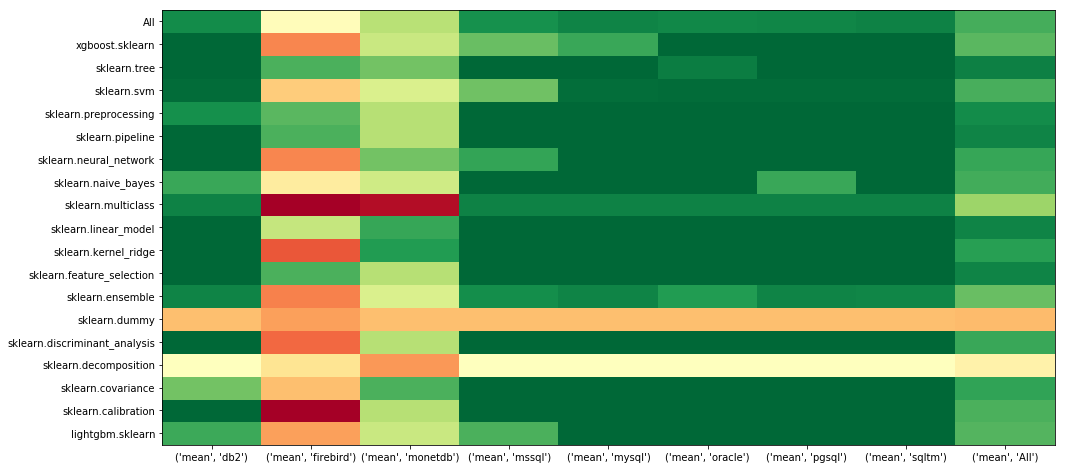

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), pvt.columns)
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [29]:
Category_Labels = df.model_category.unique()


In [30]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.dummy', 'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [31]:
for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        46
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      36
            SUCCESS                                                        15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'monetdb',  SUCCESS                                                        34
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    4
            'DBAPIError:(builtins.BrokenPipeError)                          4
            'IntegrityError:(pymonetdb.exceptions.Integrity...              4
'mssql',    SUCCESS                                                        25
            20003, b'DB-Lib error message 20003, severity 6...              5
'mysql',    SUCCESS                                                        54
'oracle',   SUCCESS                                                        54
'pgsql',    SUCCESS                                                        54
'sqltm',    SUCCESS                                                        54

mean                                             \
dialect                   db2  firebird   monetdb     mssql mysql oracle   
Model                                                                      
LGBMClassifier       0.166667  1.000000  0.333333  0.416667   0.0    0.0   
LGBMClassifier_pipe  0.000000  1.000000  1.000000       NaN   0.0    0.0   
LGBMRegressor        0.333333  0.166667  0.000000  0.000000   0.0    0.0   
LGBMRegressor_pipe   0.000000  0.166667  0.000000  0.000000   0.0    0.0   
All                  0.148148  0.722222  0.370370  0.166667   0.0    0.0   

                                           
dialect             pgsql sqltm       All  
Model                                      
LGBMClassifier        0.0   0.0  0.227778  
LGBMClassifier_pipe   0.0   0.0  0.285714  
LGBMRegressor         0.0   0.0  0.062500  
LGBMRegressor_pipe    0.0   0.0  0.020833  
All                   0.0   0.0  0.176471

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  36
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                36
'monetdb',  SUCCESS                                                  24
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mssql',    SUCCESS                                                  36
'mysql',    SUCCESS                                                  36
'oracle',   SUCCESS                                                  36
'pgsql',    SUCCESS                                                  36
'sqltm',    SUCCESS                                                  36

mean                                              \
dialect                      db2 firebird   monetdb mssql mysql oracle pgsql   
Model                                                                          
CalibratedClassifierCV       0.0      1.0  0.333333   0.0   0.0    0.0   0.0   
CalibratedClassifierCV_pipe  0.0      1.0  0.333333   0.0   0.0    0.0   0.0   
All                          0.0      1.0  0.333333   0.0   0.0    0.0   0.0   

                                             
dialect                     sqltm       All  
Model                                        
CalibratedClassifierCV        0.0  0.166667  
CalibratedClassifierCV_pipe   0.0  0.166667  
All                           0.0  0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        14
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            SUCCESS                                                         6
'monetdb',  SUCCESS                                                        15
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mssql',    SUCCESS                                                        18
'mysql',    SUCCESS                                                        18
'oracle',   SUCCESS                                                        18
'pgsql',    SUCCESS                                                        18
'sqltm',    SUCCESS                                                        18

mean                                               \
dialect                     db2  firebird   monetdb mssql mysql oracle pgsql   
Model                                                                          
EllipticEnvelope       0.333333  0.666667  0.166667   0.0   0.0    0.0   0.0   
EllipticEnvelope_pipe  0.000000  0.666667  0.166667   0.0   0.0    0.0   0.0   
All                    0.222222  0.666667  0.166667   0.0   0.0    0.0   0.0   

                                       
dialect               sqltm       All  
Model                                  
EllipticEnvelope        0.0  0.145833  
EllipticEnvelope_pipe   0.0  0.104167  
All                     0.0  0.131944

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             48
            "AttributeError:'NoneType'                               12
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             50
            SUCCESS                                                  50
            "AttributeError:'NoneType'                               12
            "DatabaseError:(fdb.fbcore.DatabaseError)                 8
'monetdb',  "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             76
            SUCCESS                                                  32
            "AttributeError:'NoneType'                               12
'mssql',    SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             48
            "AttributeError:'NoneType'                               12
'mysql',    SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             48
            "AttributeError:'NoneType'                               12
'oracle',   SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             48
            "AttributeError:'NoneType'                               12
'pgsql',    SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             48
            "AttributeError:'NoneType'                               12
'sqltm',    SUCCESS                                                  60
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             48
            "AttributeError:'NoneType'                               12

mean                                               \
dialect                    db2  firebird   monetdb mssql mysql oracle pgsql   
Model                                                                         
FactorAnalysis             0.0  0.166667  1.000000   0.0   0.0    0.0   0.0   
FastICA                    0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
IncrementalPCA             0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
KernelPCA                  1.0  1.000000  1.000000   1.0   1.0    1.0   1.0   
LatentDirichletAllocation  1.0  1.000000  1.000000   1.0   1.0    1.0   1.0   
MiniBatchSparsePCA         1.0  1.000000  1.000000   1.0   1.0    1.0   1.0   
NMF                        1.0  1.000000  1.000000   1.0   1.0    1.0   1.0   
PCA                        0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SparsePCA                  1.0  1.000000  1.000000   1.0   1.0    1.0   1.0   
TruncatedSVD               0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
All                        0.5  0.583333  0.733333   0.5   0.5    0.5   0.5   

                                           
dialect                   sqltm       All  
Model                                      
FactorAnalysis              0.0  0.145833  
FastICA                     0.0  0.062500  
IncrementalPCA              0.0  0.062500  
KernelPCA                   1.0  1.000000  
LatentDirichletAllocation   1.0  1.000000  
MiniBatchSparsePCA          1.0  1.000000  
NMF                         1.0  1.000000  
PCA                         0.0  0.062500  
SparsePCA                   1.0  1.000000  
TruncatedSVD                0.0  0.062500  
All                         0.5  0.539583

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  36
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                20
            SUCCESS                                                   7
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              5
            'DatabaseError:(fdb.fbcore.DatabaseError)                 4
'monetdb',  SUCCESS                                                  24
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             12
'mssql',    SUCCESS                                                  36
'mysql',    SUCCESS                                                  36
'oracle',   SUCCESS                                                  36
'pgsql',    SUCCESS                                                  36
'sqltm',    SUCCESS                                                  36

mean                                         \
dialect                          db2  firebird   monetdb mssql mysql oracle   
Model                                                                         
LinearDiscriminantAnalysis       0.0  1.000000  0.333333   0.0   0.0    0.0   
LinearDiscriminantAnalysis_pipe  0.0  0.416667  0.333333   0.0   0.0    0.0   
All                              0.0  0.805556  0.333333   0.0   0.0    0.0   

                                                       
dialect                         pgsql sqltm       All  
Model                                                  
LinearDiscriminantAnalysis        0.0   0.0  0.166667  
LinearDiscriminantAnalysis_pipe   0.0   0.0  0.093750  
All                               0.0   0.0  0.142361

ERROR_REPORT_FOR_CATEGORY sklearn.dummy


error_message
est_dialect error_message                                                
'db2',      "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               36
            SUCCESS                                                    18
'firebird', "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               39
            SUCCESS                                                    15
'monetdb',  ) Math exception: Numerical result out of rang             36
            SUCCESS                                                    18
'mssql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               36
            SUCCESS                                                    18
'mysql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               36
            SUCCESS                                                    18
'oracle',   "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               36
            SUCCESS                                                    18
'pgsql',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               36
            SUCCESS                                                    18
'sqltm',    "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               36
            SUCCESS                                                    18

mean                                          \
dialect                    db2  firebird   monetdb     mssql     mysql   
Model                                                                    
DummyClassifier       1.000000  1.000000  1.000000  1.000000  1.000000   
DummyClassifier_pipe  1.000000  1.000000  1.000000  1.000000  1.000000   
DummyRegressor        0.000000  0.166667  0.000000  0.000000  0.000000   
DummyRegressor_pipe   0.000000  0.166667  0.000000  0.000000  0.000000   
All                   0.666667  0.722222  0.666667  0.666667  0.666667   

                                                              
dialect                 oracle     pgsql     sqltm       All  
Model                                                         
DummyClassifier       1.000000  1.000000  1.000000  1.000000  
DummyClassifier_pipe  1.000000  1.000000  1.000000  1.000000  
DummyRegressor        0.000000  0.000000  0.000000  0.020833  
DummyRegressor_pipe   0.000000  0.000000  0.000000  0.020833  
All                   0.666667  0.666667  0.666667  0.673611

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                
'db2',      SUCCESS                                                   270
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               18
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                 189
            SUCCESS                                                    67
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               25
            "DatabaseError:(fdb.fbcore.DatabaseError)                   7
'monetdb',  SUCCESS                                                   172
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               74
            ) Math exception: Numerical result out of rang             30
            'DBAPIError:(builtins.BrokenPipeError)                     12
'mssql',    SUCCESS                                                   243
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               21
'mysql',    SUCCESS                                                   270
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               18
'oracle',   SUCCESS                                                   256
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               32
'pgsql',    SUCCESS                                                   270
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               18
'sqltm',    SUCCESS                                                   258
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               18

mean                                        \
dialect                             db2  firebird   monetdb     mssql   mysql   
Model                                                                           
AdaBoostClassifier               0.0000  1.000000  0.916667  0.083333  0.0000   
AdaBoostClassifier_pipe          0.0000  1.000000  1.000000  0.083333  0.0000   
AdaBoostRegressor                0.0000  0.166667  0.000000  0.000000  0.0000   
AdaBoostRegressor_pipe           0.0000  0.166667  0.000000  0.000000  0.0000   
BaggingClassifier                0.0000  1.000000  0.500000  0.000000  0.0000   
BaggingClassifier_pipe           0.0000  1.000000  0.500000  0.000000  0.0000   
BaggingRegressor                 0.0000  0.333333  0.000000  0.000000  0.0000   
BaggingRegressor_pipe            0.0000  0.166667  0.000000  0.000000  0.0000   
ExtraTreesClassifier             0.0000  1.000000  0.333333  0.000000  0.0000   
ExtraTreesClassifier_pipe        0.0000  1.000000  0.333333  0.000000  0.0000   
ExtraTreesRegressor              0.0000  0.500000  0.000000  0.000000  0.0000   
ExtraTreesRegressor_pipe         0.0000  0.166667  0.000000  0.000000  0.0000   
GradientBoostingClassifier       0.0000  1.000000  0.333333  0.000000  0.0000   
GradientBoostingClassifier_pipe  0.0000  1.000000  1.000000       NaN  0.0000   
GradientBoostingRegressor        0.0000  0.166667  0.000000  0.000000  0.0000   
GradientBoostingRegressor_pipe   0.0000  0.333333  0.000000  0.000000  0.0000   
IsolationForest                  1.0000  1.000000  1.000000  1.000000  1.0000   
IsolationForest_pipe             1.0000  1.000000  1.000000  1.000000  1.0000   
RandomForestClassifier           0.0000  1.000000  0.333333  0.000000  0.0000   
RandomForestClassifier_pipe      0.0000  1.000000  0.500000  0.000000  0.0000   
RandomForestRegressor            0.0000  0.166667  0.000000  0.000000  0.0000   
RandomForestRegressor_pipe       0.0000  0.333333  0.000000  0.000000  0.0000   
All                              0.0625  0.767361  0.402778  0.079545  0.0625   

                                                                       
dialect                            oracle   pgsql     sqltm       All  
Model                                                                  
AdaBoostClassifier               0.500000  0.0000  0.000000  0.312500  
AdaBoostClassifier_pipe          0.166667  0.0000  0.000000  0.281250  
AdaBoostRegressor                0.000000  0.0000  0.000000  0.020833  
AdaBoostRegressor_pipe           0.000000  0.0000  0.000000  0.020833  
BaggingClassifier                0.000000  0.0000  0.000000  0.187500  
BaggingClassifier_pipe           0.000000  0.0000  0.000000  0.187500  
BaggingRegressor                 0.000000  0.0000  0.000000  0.044444  
BaggingRegressor_pipe            0.000000  0.0000       NaN  0.023810  
ExtraTreesClassifier             0.000000  0.0000  0.000000  0.166667  
ExtraTreesClassifier_pipe        0.000000  0.0000  0.000000  0.166667  
ExtraTreesRegressor              0.000000  0.0000  0.000000  0.062500  
ExtraTreesRegressor_pipe         0.000000  0.0000  0.000000  0.020833  
GradientBoostingClassifier       0.000000  0.0000  0.000000  0.177778  
GradientBoostingClassifier_pipe  0.000000  0.0000  0.000000  0.285714  
GradientBoostingRegressor        0.000000  0.0000  0.000000  0.020833  
GradientBoostingRegressor_pipe   0.000000  0.0000  0.000000  0.041667  
IsolationForest                  1.000000  1.0000  1.000000  1.000000  
IsolationForest_pipe             1.000000  1.0000  1.000000  1.000000  
RandomForestClassifier           0.000000  0.0000  0.000000  0.166667  
RandomForestClassifier_pipe      0.000000  0.0000  0.000000  0.187500  
RandomForestRegressor            0.000000  0.0000  0.000000  0.020833  
RandomForestRegressor_pipe       0.000000  0.0000  0.000000  0.041667  
All                              0.111111  0.0625  0.065217  0.203704

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 108
'firebird', SUCCESS                                                  90
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             18
'monetdb',  SUCCESS                                                  72
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             36
'mssql',    SUCCESS                                                 108
'mysql',    SUCCESS                                                 108
'oracle',   SUCCESS                                                 108
'pgsql',    SUCCESS                                                 108
'sqltm',    SUCCESS                                                 108

mean                                               \
dialect                  db2  firebird   monetdb mssql mysql oracle pgsql   
Model                                                                       
GenericUnivariateSelect  0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
RFE                      0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
RFECV                    0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SelectFdr                0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SelectFpr                0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SelectFromModel          0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SelectFwe                0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SelectKBest              0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
SelectPercentile         0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   
All                      0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   

                                       
dialect                 sqltm     All  
Model                                  
GenericUnivariateSelect   0.0  0.0625  
RFE                       0.0  0.0625  
RFECV                     0.0  0.0625  
SelectFdr                 0.0  0.0625  
SelectFpr                 0.0  0.0625  
SelectFromModel           0.0  0.0625  
SelectFwe                 0.0  0.0625  
SelectKBest               0.0  0.0625  
SelectPercentile          0.0  0.0625  
All                       0.0  0.0625

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        18
'firebird', "DatabaseError:(fdb.fbcore.DatabaseError)                      11
            SUCCESS                                                         3
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'monetdb',  SUCCESS                                                        16
            ) 22003!overflow in calculation 194955857131449...              2
'mssql',    SUCCESS                                                        18
'mysql',    SUCCESS                                                        18
'oracle',   SUCCESS                                                        18
'pgsql',    SUCCESS                                                        18
'sqltm',    SUCCESS                                                        18

mean                                                     \
dialect           db2  firebird   monetdb mssql mysql oracle pgsql sqltm   
Model                                                                      
KernelRidge       0.0  1.000000  0.166667   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.0  0.500000  0.000000   0.0   0.0    0.0   0.0   0.0   
All               0.0  0.833333  0.111111   0.0   0.0    0.0   0.0   0.0   

                            
dialect                All  
Model                       
KernelRidge       0.145833  
KernelRidge_pipe  0.062500  
All               0.118056

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 612
'firebird', SUCCESS                                                 392
            "DatabaseError:(fdb.fbcore.DatabaseError)               112
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS            100
            'DatabaseError:(fdb.fbcore.DatabaseError)                 8
'monetdb',  SUCCESS                                                 528
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             84
'mssql',    SUCCESS                                                 612
'mysql',    SUCCESS                                                 612
'oracle',   SUCCESS                                                 612
'pgsql',    SUCCESS                                                 612
'sqltm',    SUCCESS                                                 612

mean                                         \
dialect                           db2  firebird   monetdb mssql mysql oracle   
Model                                                                          
ARDRegression                     0.0  0.500000  0.000000   0.0   0.0    0.0   
ARDRegression_pipe                0.0  0.166667  0.000000   0.0   0.0    0.0   
BayesianRidge                     0.0  0.500000  0.000000   0.0   0.0    0.0   
BayesianRidge_pipe                0.0  0.166667  0.000000   0.0   0.0    0.0   
ElasticNet                        0.0  0.500000  0.000000   0.0   0.0    0.0   
ElasticNetCV                      0.0  0.500000  0.000000   0.0   0.0    0.0   
ElasticNetCV_pipe                 0.0  0.166667  0.000000   0.0   0.0    0.0   
ElasticNet_pipe                   0.0  0.166667  0.000000   0.0   0.0    0.0   
Lars                              0.0  0.500000  0.000000   0.0   0.0    0.0   
LarsCV                            0.0  0.500000  0.000000   0.0   0.0    0.0   
LarsCV_pipe                       0.0  0.166667  0.000000   0.0   0.0    0.0   
Lars_pipe                         0.0  0.166667  0.000000   0.0   0.0    0.0   
Lasso                             0.0  0.500000  0.000000   0.0   0.0    0.0   
LassoCV                           0.0  0.500000  0.000000   0.0   0.0    0.0   
LassoCV_pipe                      0.0  0.166667  0.000000   0.0   0.0    0.0   
LassoLars                         0.0  0.500000  0.000000   0.0   0.0    0.0   
LassoLarsCV                       0.0  0.500000  0.000000   0.0   0.0    0.0   
LassoLarsCV_pipe                  0.0  0.166667  0.000000   0.0   0.0    0.0   
LassoLarsIC                       0.0  0.166667  0.000000   0.0   0.0    0.0   
LassoLarsIC_pipe                  0.0  0.166667  0.000000   0.0   0.0    0.0   
LassoLars_pipe                    0.0  0.166667  0.000000   0.0   0.0    0.0   
Lasso_pipe                        0.0  0.166667  0.000000   0.0   0.0    0.0   
LinearRegression                  0.0  0.500000  0.000000   0.0   0.0    0.0   
LinearRegression_pipe             0.0  0.166667  0.000000   0.0   0.0    0.0   
LogisticRegression                0.0  1.000000  0.333333   0.0   0.0    0.0   
LogisticRegressionCV              0.0  0.833333  0.333333   0.0   0.0    0.0   
LogisticRegressionCV_pipe         0.0  0.416667  0.333333   0.0   0.0    0.0   
LogisticRegression_pipe           0.0  0.416667  0.333333   0.0   0.0    0.0   
OrthogonalMatchingPursuit         0.0  0.166667  0.000000   0.0   0.0    0.0   
OrthogonalMatchingPursuitCV       0.0  0.166667  0.000000   0.0   0.0    0.0   
OrthogonalMatchingPursuitCV_pipe  0.0  0.166667  0.000000   0.0   0.0    0.0   
OrthogonalMatchingPursuit_pipe    0.0  0.166667  0.000000   0.0   0.0    0.0   
PassiveAggressiveClassifier       0.0  0.166667  0.333333   0.0   0.0    0.0   
PassiveAggressiveClassifier_pipe  0.0  0.166667  0.333333   0.0   0.0    0.0   
PassiveAggressiveRegressor        0.0  0.333333  0.000000   0.0   0.0    0.0   
PassiveAggressiveRegressor_pipe   0.0  0.166667  0.000000   0.0   0.0    0.0   
Perceptron                        0.0  0.166667  0.333333   0.0   0.0    0.0   
Perceptron_pipe                   0.0  0.166667  0.333333   0.0   0.0    0.0   
RANSACRegressor                   0.0  0.500000  0.000000   0.0   0.0    0.0   
RANSACRegressor_pipe              0.0  0.166667  0.000000   0.0   0.0    0.0   
Ridge                             0.0  0.500000  0.000000   0.0   0.0    0.0   
RidgeCV                           0.0  0.500000  0.000000   0.0   0.0    0.0   
RidgeCV_pipe                      0.0  0.166667  0.000000   0.0   0.0    0.0   
RidgeClassifier                   0.0  0.250000  0.333333   0.0   0.0    0.0   
RidgeClassifierCV                 0.0  0.583333  0.333333   0.0   0.0    0.0   
RidgeClassifierCV_pipe            0.0  0.166667  0.333333   0.0   0.0    0.0   
RidgeClassifier_pipe              0.0  0.166667  0.333333   0.0   0.0    0.0   
Ridge_pipe                       

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                                
'db2',      SUCCESS                                                    68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                4
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                  64
            "DatabaseError:(fdb.fbcore.DatabaseError)                   7
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                1
'monetdb',  'ResourceClosedError:This                                  36
            ) Math exception: Numerical result out of rang             22
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS               12
            SUCCESS                                                     2
'mssql',    SUCCESS                                                    68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                4
'mysql',    SUCCESS                                                    68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                4
'oracle',   SUCCESS                                                    68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                4
'pgsql',    SUCCESS                                                    68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                4
'sqltm',    SUCCESS                                                    68
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                4

mean                                         \
dialect                        db2 firebird   monetdb     mssql     mysql   
Model                                                                       
OneVsOneClassifier        0.000000      1.0  1.000000  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000      1.0  1.000000  0.000000  0.000000   
OneVsRestClassifier       0.166667      1.0  0.916667  0.166667  0.166667   
OneVsRestClassifier_pipe  0.000000      1.0  1.000000  0.000000  0.000000   
All                       0.055556      1.0  0.972222  0.055556  0.055556   

                                                                  
dialect                     oracle     pgsql     sqltm       All  
Model                                                             
OneVsOneClassifier        0.000000  0.000000  0.000000  0.250000  
OneVsOneClassifier_pipe   0.000000  0.000000  0.000000  0.250000  
OneVsRestClassifier       0.166667  0.166667  0.166667  0.364583  
OneVsRestClassifier_pipe  0.000000  0.000000  0.000000  0.250000  
All                       0.055556  0.055556  0.055556  0.288194

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        72
            : Fetch Failure: [IBM][CLI Driver][DB2/LINUXX86...             12
'firebird', SUCCESS                                                        37
            "DatabaseError:(fdb.fbcore.DatabaseError)                      27
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
            'DatabaseError:(fdb.fbcore.DatabaseError)                       8
'monetdb',  SUCCESS                                                        52
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   28
            ) Math exception: Numerical result out of rang                  4
'mssql',    SUCCESS                                                        84
'mysql',    SUCCESS                                                        84
'oracle',   SUCCESS                                                        84
'pgsql',    SUCCESS                                                        72
            ) value out of range: underflo                                 12
'sqltm',    SUCCESS                                                        84

mean                                                   \
dialect                db2  firebird   monetdb mssql mysql oracle     pgsql   
Model                                                                         
BernoulliNB       0.000000  1.000000  0.333333   0.0   0.0    0.0  0.000000   
BernoulliNB_pipe  0.000000  1.000000  0.333333   0.0   0.0    0.0  0.000000   
GaussianNB        0.500000  0.166667  0.500000   0.0   0.0    0.0  0.500000   
GaussianNB_pipe   0.000000  0.416667  0.333333   0.0   0.0    0.0  0.000000   
MultinomialNB     0.000000  0.166667  0.333333   0.0   0.0    0.0  0.000000   
All               0.142857  0.559524  0.380952   0.0   0.0    0.0  0.142857   

                                  
dialect          sqltm       All  
Model                             
BernoulliNB        0.0  0.166667  
BernoulliNB_pipe   0.0  0.166667  
GaussianNB         0.0  0.208333  
GaussianNB_pipe    0.0  0.093750  
MultinomialNB      0.0  0.062500  
All                0.0  0.153274

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        54
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      36
            SUCCESS                                                        13
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    5
'monetdb',  SUCCESS                                                        42
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   12
'mssql',    SUCCESS                                                        26
            8632, b'Internal error: An expression services ...              4
'mysql',    SUCCESS                                                        54
'oracle',   SUCCESS                                                        54
'pgsql',    SUCCESS                                                        54
'sqltm',    SUCCESS                                                        54

mean                                                   \
dialect             db2  firebird   monetdb     mssql mysql oracle pgsql   
Model                                                                      
MLPClassifier       0.0  1.000000  0.333333  0.000000   0.0    0.0   0.0   
MLPClassifier_pipe  0.0  1.000000  0.333333       NaN   0.0    0.0   0.0   
MLPRegressor        0.0  0.166667  0.000000  0.000000   0.0    0.0   0.0   
MLPRegressor_pipe   0.0  0.500000  0.000000  0.666667   0.0    0.0   0.0   
All                 0.0  0.759259  0.222222  0.133333   0.0    0.0   0.0   

                                    
dialect            sqltm       All  
Model                               
MLPClassifier        0.0  0.177778  
MLPClassifier_pipe   0.0  0.190476  
MLPRegressor         0.0  0.020833  
MLPRegressor_pipe    0.0  0.145833  
All                  0.0  0.139706

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  48
'firebird', SUCCESS                                                  40
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              8
'monetdb',  SUCCESS                                                  32
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             16
'mssql',    SUCCESS                                                  48
'mysql',    SUCCESS                                                  48
'oracle',   SUCCESS                                                  48
'pgsql',    SUCCESS                                                  48
'sqltm',    SUCCESS                                                  48

mean                                                           
dialect        db2  firebird   monetdb mssql mysql oracle pgsql sqltm     All
Model                                                                        
FeatureUnion   0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   0.0  0.0625
Pipeline       0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   0.0  0.0625
Pipeline_pipe  0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   0.0  0.0625
All            0.0  0.166667  0.333333   0.0   0.0    0.0   0.0   0.0  0.0625

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       132
            'DBAPIError:(ibm_db_dbi.Error)                                 12
'firebird', SUCCESS                                                       117
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   23
            'DatabaseError:(fdb.fbcore.DatabaseError)                       4
'monetdb',  SUCCESS                                                        96
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   47
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              1
'mssql',    SUCCESS                                                       144
'mysql',    SUCCESS                                                       144
'oracle',   SUCCESS                                                       144
'pgsql',    SUCCESS                                                       144
'sqltm',    SUCCESS                                                       144

mean                                               \
dialect                   db2  firebird   monetdb mssql mysql oracle pgsql   
Model                                                                        
Binarizer            0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
Imputer              0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
LabelBinarizer       0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
LabelEncoder         0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
MaxAbsScaler         0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
MinMaxScaler         0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
Normalizer           0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
OneHotEncoder        0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
PolynomialFeatures   0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
QuantileTransformer  1.000000  0.416667  0.333333   0.0   0.0    0.0   0.0   
RobustScaler         0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
StandardScaler       0.000000  0.166667  0.333333   0.0   0.0    0.0   0.0   
All                  0.083333  0.187500  0.333333   0.0   0.0    0.0   0.0   

                                     
dialect             sqltm       All  
Model                                
Binarizer             0.0  0.062500  
Imputer               0.0  0.062500  
LabelBinarizer        0.0  0.062500  
LabelEncoder          0.0  0.062500  
MaxAbsScaler          0.0  0.062500  
MinMaxScaler          0.0  0.062500  
Normalizer            0.0  0.062500  
OneHotEncoder         0.0  0.062500  
PolynomialFeatures    0.0  0.062500  
QuantileTransformer   0.0  0.218750  
RobustScaler          0.0  0.062500  
StandardScaler        0.0  0.062500  
All                   0.0  0.075521

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       178
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      74
            SUCCESS                                                        65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   26
            "DatabaseError:(fdb.fbcore.DatabaseError)                      15
'monetdb',  SUCCESS                                                        93
            'DBAPIError:(builtins.BrokenPipeError)                         32
            'ResourceClosedError:This                                      16
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                   15
'mssql',    SUCCESS                                                       122
            20003, b'DB-Lib error message 20003, severity 6...             25
            8623, b'The query processor ran out of internal...              9
'mysql',    SUCCESS                                                       142
            1969, 'Query execution was interrupted (max_sta...              2
'oracle',   SUCCESS                                                       178
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'pgsql',    SUCCESS                                                       178
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2
'sqltm',    SUCCESS                                                       178
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    2

mean                                                    \
dialect                db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                          
LinearSVC         0.000000  0.416667  0.333333  0.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.166667  0.333333  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  1.000000  1.000000  0.666667       NaN  0.000000   
NuSVC_pipe        0.166667  1.000000  1.000000  0.666667       NaN  0.166667   
NuSVR             0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.666667  0.166667  0.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  1.000000  0.166667  0.000000  0.000000  0.000000   
SVC               0.000000  1.000000  1.000000  0.833333  0.000000  0.000000   
SVC_pipe          0.000000  1.000000       NaN       NaN  0.166667  0.000000   
SVR               0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
All               0.011111  0.638889  0.403846  0.217949  0.013889  0.011111   

                                                
dialect              pgsql     sqltm       All  
Model                                           
LinearSVC         0.000000  0.000000  0.093750  
LinearSVC_pipe    0.000000  0.000000  0.062500  
LinearSVR         0.000000  0.000000  0.041667  
LinearSVR_pipe    0.000000  0.000000  0.020833  
NuSVC             0.000000  0.000000  0.380952  
NuSVC_pipe        0.166667  0.166667  0.476190  
NuSVR             0.000000  0.000000  0.020833  
NuSVR_pipe        0.000000  0.000000  0.062500  
OneClassSVM       0.000000  0.000000  0.104167  
OneClassSVM_pipe  0.000000  0.000000  0.145833  
SVC               0.000000  0.000000  0.273810  
SVC_pipe          0.000000  0.000000  0.194444  
SVR               0.000000  0.000000  0.041667  
SVR_pipe          0.000000  0.000000  0.062500  
All               0.011111  0.011111  0.163717

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                 108
'firebird', SUCCESS                                                  90
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             18
'monetdb',  SUCCESS                                                  84
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             24
'mssql',    SUCCESS                                                 108
'mysql',    SUCCESS                                                 108
'oracle',   SUCCESS                                                 103
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              5
'pgsql',    SUCCESS                                                 108
'sqltm',    SUCCESS                                                 108

mean                                            \
dialect                      db2  firebird   monetdb mssql mysql    oracle   
Model                                                                        
DecisionTreeClassifier       0.0  0.166667  0.333333   0.0   0.0  0.000000   
DecisionTreeClassifier_pipe  0.0  0.166667  0.333333   0.0   0.0  0.000000   
DecisionTreeRegressor        0.0  0.166667  0.000000   0.0   0.0  0.000000   
DecisionTreeRegressor_pipe   0.0  0.166667  0.000000   0.0   0.0  0.000000   
ExtraTreeClassifier          0.0  0.166667  0.333333   0.0   0.0  0.000000   
ExtraTreeClassifier_pipe     0.0  0.166667  0.333333   0.0   0.0  0.333333   
ExtraTreeRegressor           0.0  0.166667  0.000000   0.0   0.0  0.000000   
ExtraTreeRegressor_pipe      0.0  0.166667  0.000000   0.0   0.0  0.166667   
All                          0.0  0.166667  0.222222   0.0   0.0  0.046296   

                                                   
dialect                     pgsql sqltm       All  
Model                                              
DecisionTreeClassifier        0.0   0.0  0.062500  
DecisionTreeClassifier_pipe   0.0   0.0  0.062500  
DecisionTreeRegressor         0.0   0.0  0.020833  
DecisionTreeRegressor_pipe    0.0   0.0  0.020833  
ExtraTreeClassifier           0.0   0.0  0.062500  
ExtraTreeClassifier_pipe      0.0   0.0  0.104167  
ExtraTreeRegressor            0.0   0.0  0.020833  
ExtraTreeRegressor_pipe       0.0   0.0  0.041667  
All                           0.0   0.0  0.054398

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        54
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                      36
            SUCCESS                                                        13
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            "DatabaseError:(fdb.fbcore.DatabaseError)                       2
'monetdb',  SUCCESS                                                        34
            'DBAPIError:(builtins.BrokenPipeError)                         12
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    8
'mssql',    SUCCESS                                                        43
            20003, b'DB-Lib error message 20003, severity 6...             11
'mysql',    SUCCESS                                                        36
            2002, 'Can't connect to local MySQL server thro...              4
            2013, 'Lost connection to MySQL server at 'read...              2
'oracle',   SUCCESS                                                        54
'pgsql',    SUCCESS                                                        54
'sqltm',    SUCCESS                                                        54

mean                                                       \
dialect             db2  firebird   monetdb     mssql     mysql oracle pgsql   
Model                                                                          
XGBClassifier       0.0  1.000000  0.333333  0.083333  0.000000    0.0   0.0   
XGBClassifier_pipe  0.0  1.000000  1.000000  0.750000  0.000000    0.0   0.0   
XGBRegressor        0.0  0.333333  0.000000  0.000000  1.000000    0.0   0.0   
XGBRegressor_pipe   0.0  0.166667  0.000000  0.000000       NaN    0.0   0.0   
All                 0.0  0.759259  0.370370  0.203704  0.142857    0.0   0.0   

                                    
dialect            sqltm       All  
Model                               
XGBClassifier        0.0  0.177083  
XGBClassifier_pipe   0.0  0.343750  
XGBRegressor         0.0  0.111111  
XGBRegressor_pipe    0.0  0.023810  
All                  0.0  0.185714

In [32]:
df[df.model_category == "bad_category"]

,Model,est_dialect,DSN,status,error_message,model_category,status_2,dialect
